In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Justus Sagemüller  (KTH)
#   Authored by:  Margaret Duff (STFC-UKRI)

# A CIL-pytorch example using DeepInverse using a pre-trained denoiser in the CIL FISTA algorithm 

This notebook covers: 
- How to set up an environment with CIL and pytorch and deep inverse 
- How to create a CIL function to wrap a pytorch function or operator 
- Examples of image reconstruction using a pre-trained denoiser in CIL 
- Timings of the data copies between pytorch and CIL 

This notebook is a result of the CCPi/SyneRBi Hackathon on CIL/SIRF/Pytorch integration. Note that this notebook is the result of a day of hacking is therefore not a complete piece of work. Ideas for future work are presented at the end. 

In [2]:

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, Function

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D

# Import from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math
from time import time
import gc
import numpy as np

## CIL Version 24.3.1

In [3]:
import cil
print(cil.__version__)

24.3.1.dev20+ga06f691f1


## Dataset 

We use the parallel beam steel wire dataset from CIL dataexamples. We crop the data and slice the data to give a limited angle dataset of just 15 angles. 

In [4]:
# Load the example data set
from cil.utilities.dataexample import SYNCHROTRON_PARALLEL_BEAM_DATA
data_sync = SYNCHROTRON_PARALLEL_BEAM_DATA.get()

# Preprocessing
scale = data_sync.get_slice(vertical=20).mean()
data_sync = data_sync/scale
data_sync = TransmissionAbsorptionConverter()(data_sync)
data_sync = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data_sync)

# Crop data and reorder for ASTRA backend
data90 = Slicer(roi={'angle':(0,90), 
                     'horizontal':(20,140,1)})(data_sync)
data90.reorder(order='astra')

# Set up a 15-angle dataset
data15 = Slicer(roi={'angle': (0,90,6)})(data90)


We reconstruct the 15-angle dataset using FBP and visualise the results 

In [5]:
#Reconstruct using FBP
recon15 = FBP(data15, backend='astra').run(verbose=0)

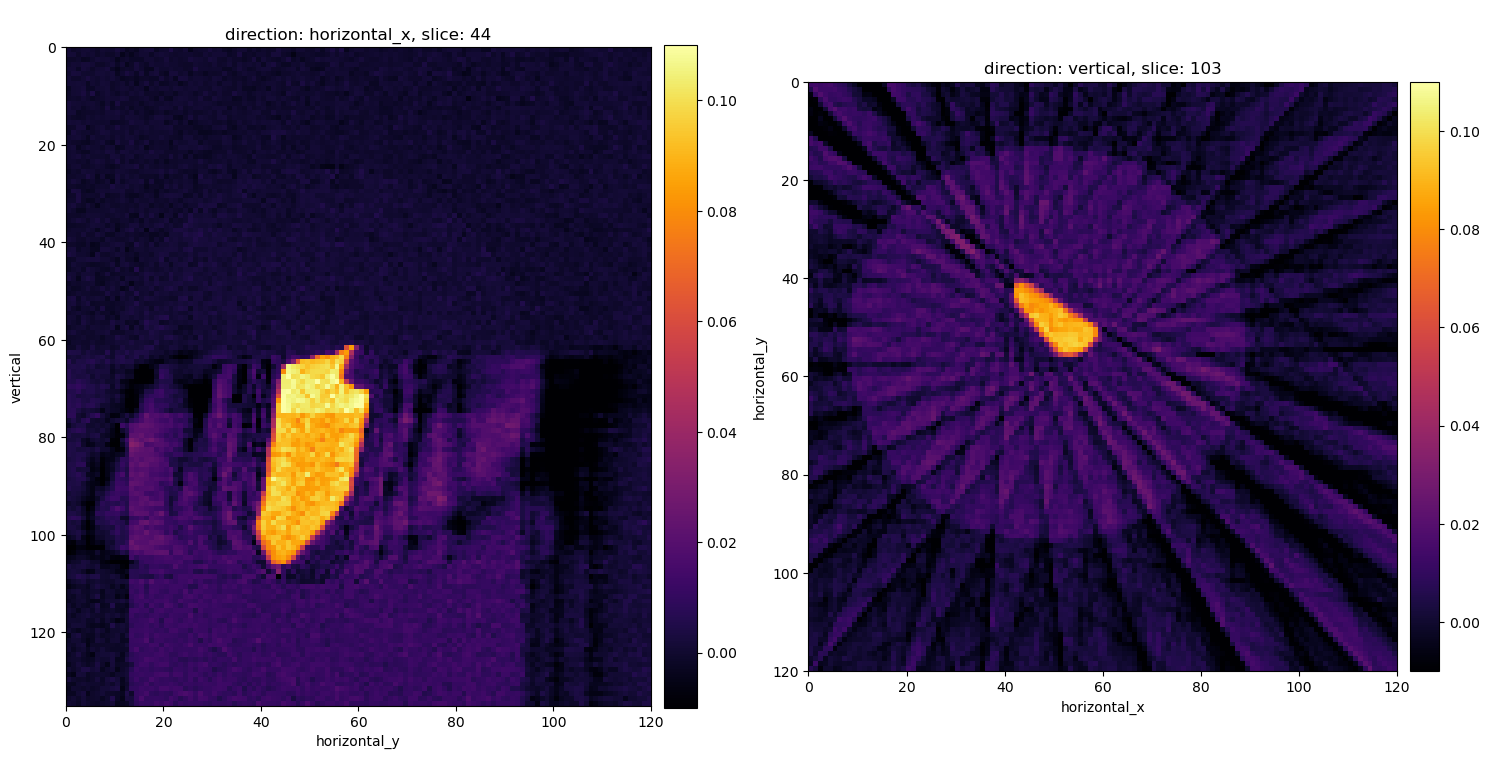

In [6]:


# Define custom parameters for show2D for visualizing all reconstructions consistently
sx = 44
sz = 103
ca1 = -0.01
ca2 =  0.11
slices = [('horizontal_x',sx),('vertical',sz)]

show2D(recon15, 
     slice_list=slices, cmap='inferno', fix_range=(ca1,ca2), origin='upper-left');

## Total Variation regularised reconstruction 

We first reconstruct with TV regularisation. We use the FISTA algorithm to solve the optimisation problem. 

In [7]:
ag = data15.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")
b = data15

F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
alpha = 0.02
GTV = alpha*FGP_TV(device='gpu', nonnegativity=True) 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

  0%|          | 0/200 [00:00<?, ?it/s]

TV regularisation reduces many of the limited angle artefacts giving an almost cartoon like image, with constant areas and sharp edges. 

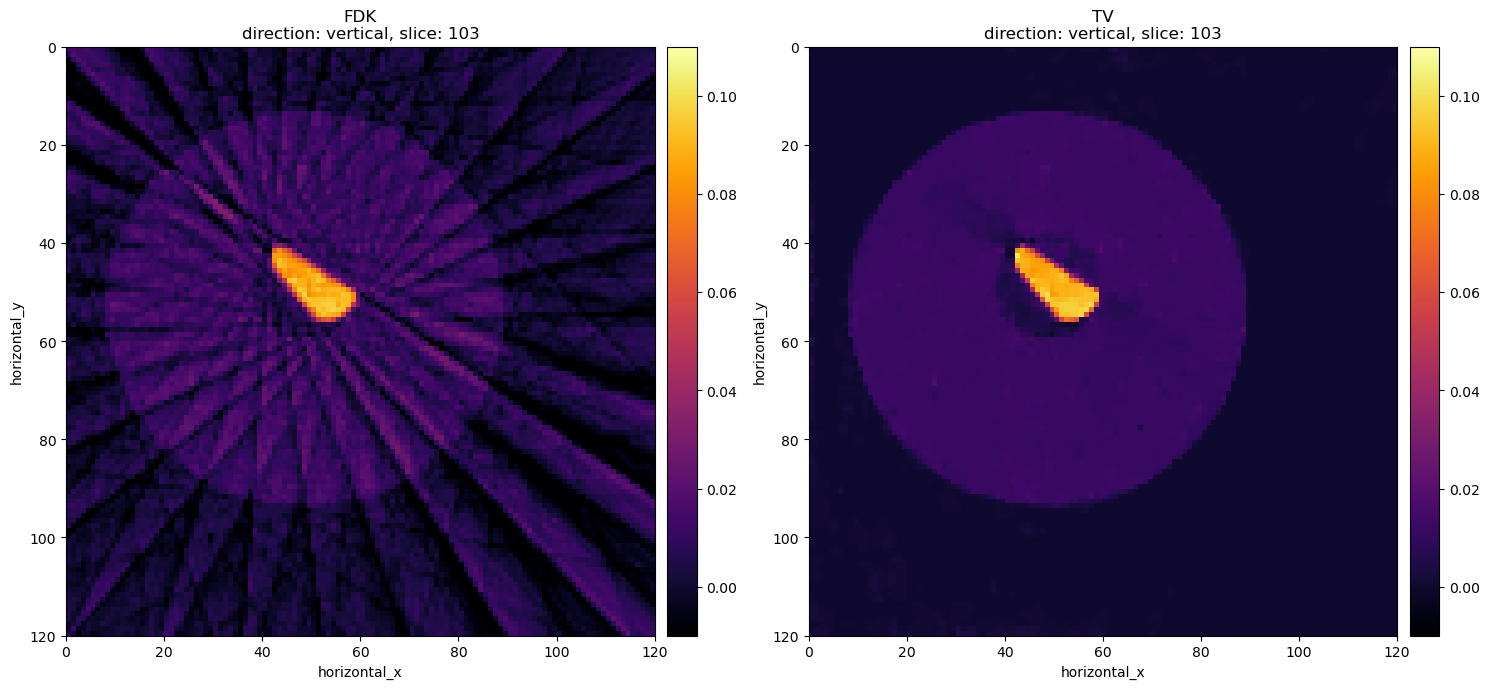

In [8]:
show2D([recon15, myFISTATV.solution ], title=['FDK', 'TV'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left');


## FISTA with the proximal step replaced by a learned denoiser 

When we use FISTA to minimise $f(x)+\lambda g(x)$, such as above with $g$ was a regularisation parameter multiplied by a regularisation constant, in each FISTA update step, for current iterate $x_k$ and stepsize $\alpha_l$ we do the calculation: $$ x_{k+1} = \mathrm{prox}_{\alpha_k \ \lambda g} (x_k-\alpha_k \nabla f(x_k))$$

Where 

$$\mathrm{prox}_{\alpha \  \lambda g}(x)=\arg\min_u \frac{1}{2}\| x-u\|+ \alpha\lambda g(u)$$ 

this last equation looks like a denoiser with regulariser $g$ and regularisation parameter $\alpha\lambda$. 

The idea of Plug and Play denoisers is to replace the proximal step with any denoiser. This could be a neural network trained to remove noise from images or it could be something non-learned e.g. BM3D. We call this implicit regularisation: the denoiser will implicitly regularise the resulting solution but, in most cases, the equivalent regularisation function can't be written out explicitly. 

In order to implement this in CIL, we use the pytorch library. To install pytorch and CIL we recommend [pip installing](https://pytorch.org/get-started/locally/) into an environment that contains CIL. 

We define a CIL Function that evaluates to 0 when it is called, but, importantly, when it's proximal is called it transforms the CIL data container to a torch tensor and passes this torch tensor along with the scalar value used in the proximal as a noise level to the torch denoiser. It then wraps the result in a CIL data container before returning. 

In [9]:

import torch

class DenoiserProximal(Function):
    """
    DenoiserProximal is a custom CIL function that, when evaluated (__call__), returns 0. 
    It implements a proximal operator via a torch-based denoiser. When the
    proximal() method is called, the input CIL data container is converted into a PyTorch
    tensor, processed with the denoiser model using the specified noise level (tau), and then
    wrapped back into a CIL data container.

    Parameters:
        model: The torch-based denoiser model which accepts an input tensor and a noise level.
        device: The torch device (e.g., 'cuda' or 'cpu') on which the model runs.
    """

    def __init__(self, model, device='cuda'):
        self.device = torch.device(device)
        self.model = model 
        super(DenoiserProximal, self).__init__()

    def __call__(self, x):
        # This function merely returns 0 as its evaluation.
        return 0 

    def cil_to_torch(self, x):
        """
        Convert a CIL data container to a PyTorch tensor.

        This method extracts the 'array' attribute from the input CIL data container,
        moves the data to the designated device, and adjusts the tensor's shape by squeezing
        out the first dimension and adding a channel dimension. This reshaped tensor is then
        ready to be passed to the denoiser model.

        Parameters:
            x: A CIL data container with an 'array' attribute containing the data.

        Returns:
            torch.Tensor: A PyTorch tensor formatted for the denoiser model.
        """
        return (torch.tensor(x.array, device=self.device)
                .squeeze(0).unsqueeze(1))
    
    def torch_to_cil(self, x_tens, out):
        """
        Convert a PyTorch tensor to a CIL data container.

        After the denoiser processes the input, this method converts the resulting PyTorch tensor
        back into the format expected by a CIL data container. It performs a reverse of the shaping operations
        applied in cil_to_torch (i.e., removing the channel dimension and adding back the batch dimension)
        and updates the 'array' attribute of the output container.

        Parameters:
            x_tens (torch.Tensor): The processed tensor from the denoiser.
            out: A pre-allocated CIL data container to store the final output data.
        """
        out.array[:] = (x_tens.squeeze(1).unsqueeze(0)
                        .detach().cpu().numpy())
            
    def proximal(self, x, tau, out=None):
        """
        Apply the proximal operator via a torch-based denoiser to a CIL data container.

        This method implements the proximal step by first converting the input CIL data container
        to a PyTorch tensor using cil_to_torch. The tensor is then passed to the denoiser model along
        with the provided noise level 'tau'. The output tensor is converted back into a CIL data container using
        torch_to_cil. If no output container is provided (i.e., out is None), a new container is allocated
        based on the geometry of x.

        Parameters:
            x: The input CIL data container to be processed.
            tau (float): A scalar noise level parameter passed to the denoiser model.
            out: (Optional) A pre-allocated CIL data container for returning the result. If not provided,
                 a new container is allocated.

        Returns:
            A CIL data container containing the denoiser-processed data.
        """
        if out is None: 
            out = x.geometry.allocate(None)

        with torch.no_grad():
            x_torch = self.cil_to_torch(x)
            x_torch = self.model(x_torch, tau)
            self.torch_to_cil(x_torch, out)
        return out 
        

With this formulation can we use the FISTA algorithm as we would usually do: 

```python
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
model = # denoiser model here
lamb = # regularisation parameter
regulariser = lamb*DenoiserProximal(model)
myFISTADnCNN = FISTA(f=F, 
                  g=regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)

```


[The deep inverse library has a range of denoisers](https://deepinv.github.io/deepinv/user_guide/reconstruction/denoisers.html#denoisers) that take a noisy image as input and return a denoised image. Some of these come with pre-trained weights.  We play with a couple of these pre-trained denoisers in the next few sections.

To install deep inverse, follow the instructions [here. ](https://deepinv.github.io/deepinv/quickstart.html)


In [10]:
import deepinv

In the below cell, set the device to be used by torch, either a GPU, if available, or the CPU

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### DnCCN - not noise level aware

The DnCNN architecture was introduced in https://arxiv.org/abs/1608.03981 and is composed of a series of convolutional layers with ReLU activation functions. This denoiser takes an image and returns a denoised image and is "not noise level aware", i.e. the model does not need or use any information about the amount of noise in the image. 

This means that the in the calculation of the proximal, the `tau` constant is not used and thus changing the regularisation parameter has no effect and the model gets no information on the current step size. 

We run FISTA with the denoiser as a replacement for the proximal of the regulariser. We plot the results every 50 iterations for 200 iterations. 

/home/bih17925/miniconda3/envs/cil_torch/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  0%|          | 0/50 [00:00<?, ?it/s]

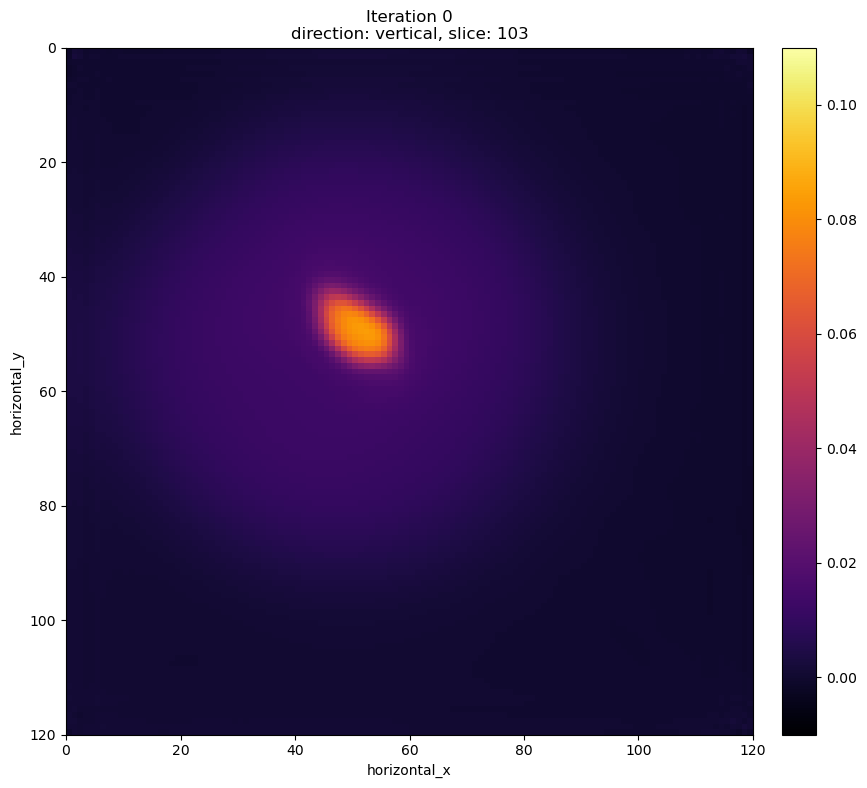

 51%|#####1    | 51/100 [00:00<?, ?it/s]

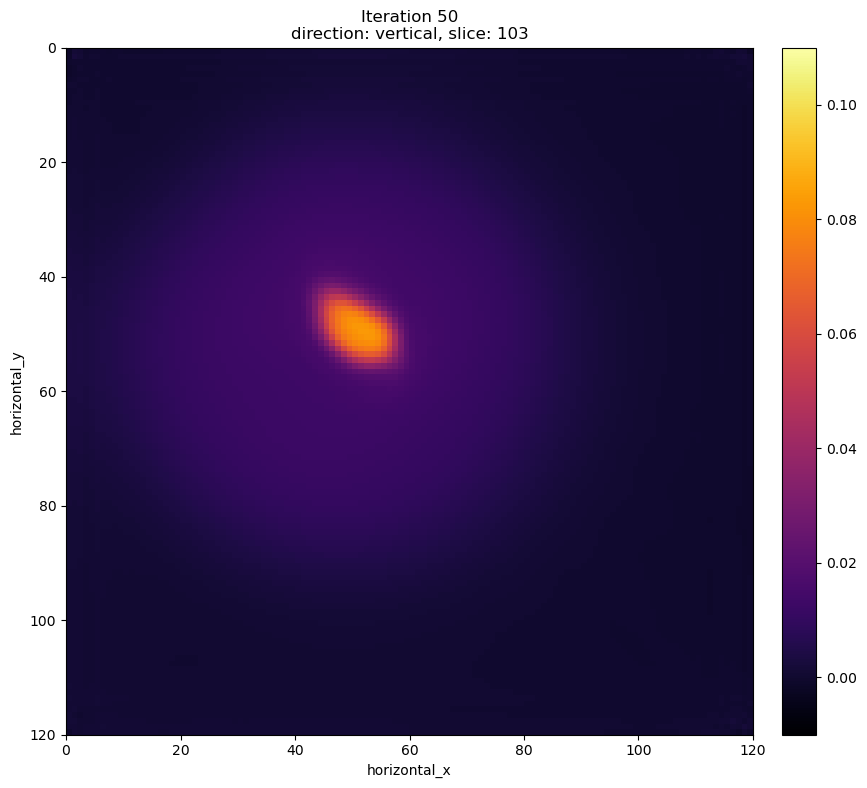

 67%|######7   | 101/150 [00:00<?, ?it/s]

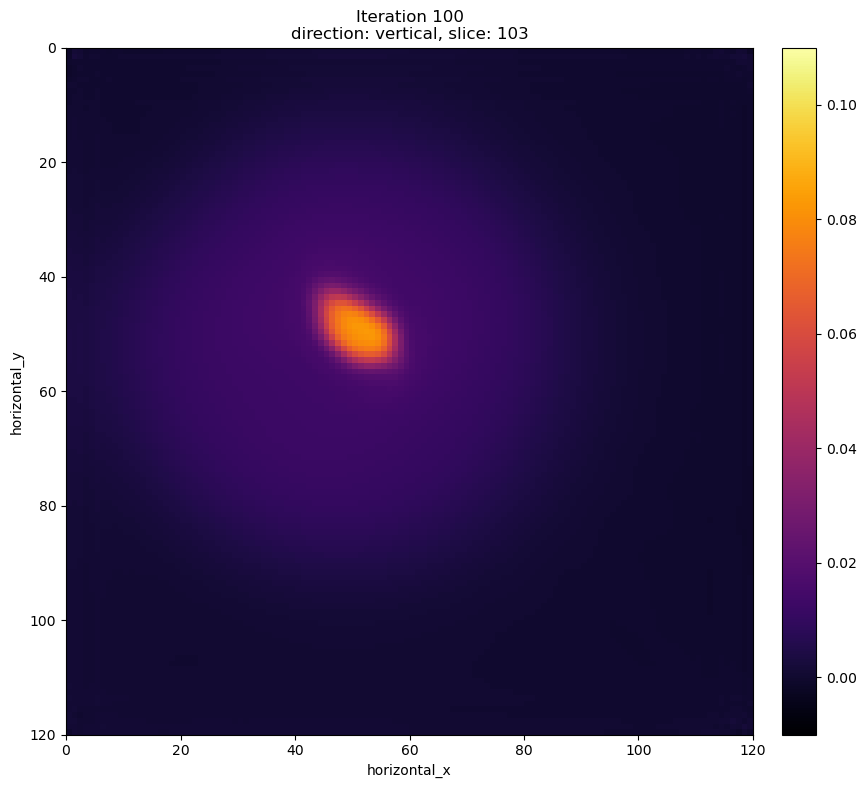

 76%|#######5  | 151/200 [00:00<?, ?it/s]

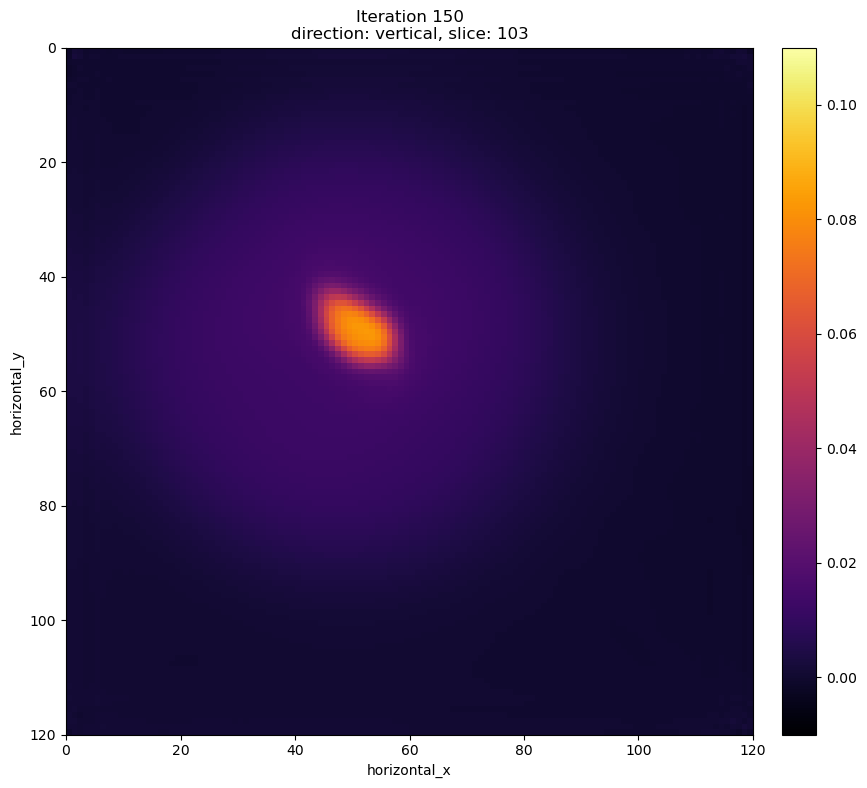

In [12]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
model = deepinv.models.DnCNN(in_channels=1, out_channels=1, pretrained='download_lipschitz', device=device)
regulariser = DenoiserProximal(model, device)
#TODO: FISTA OR ISTA? 
myFISTADnCNN = FISTA(f=F, 
                  g=regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADnCNN.run(50,verbose=1)
    show2D(myFISTADnCNN.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


Comparing the result to the FDK and TV results, the final image is defintely oversmoothed and we have lost information on the edges.  

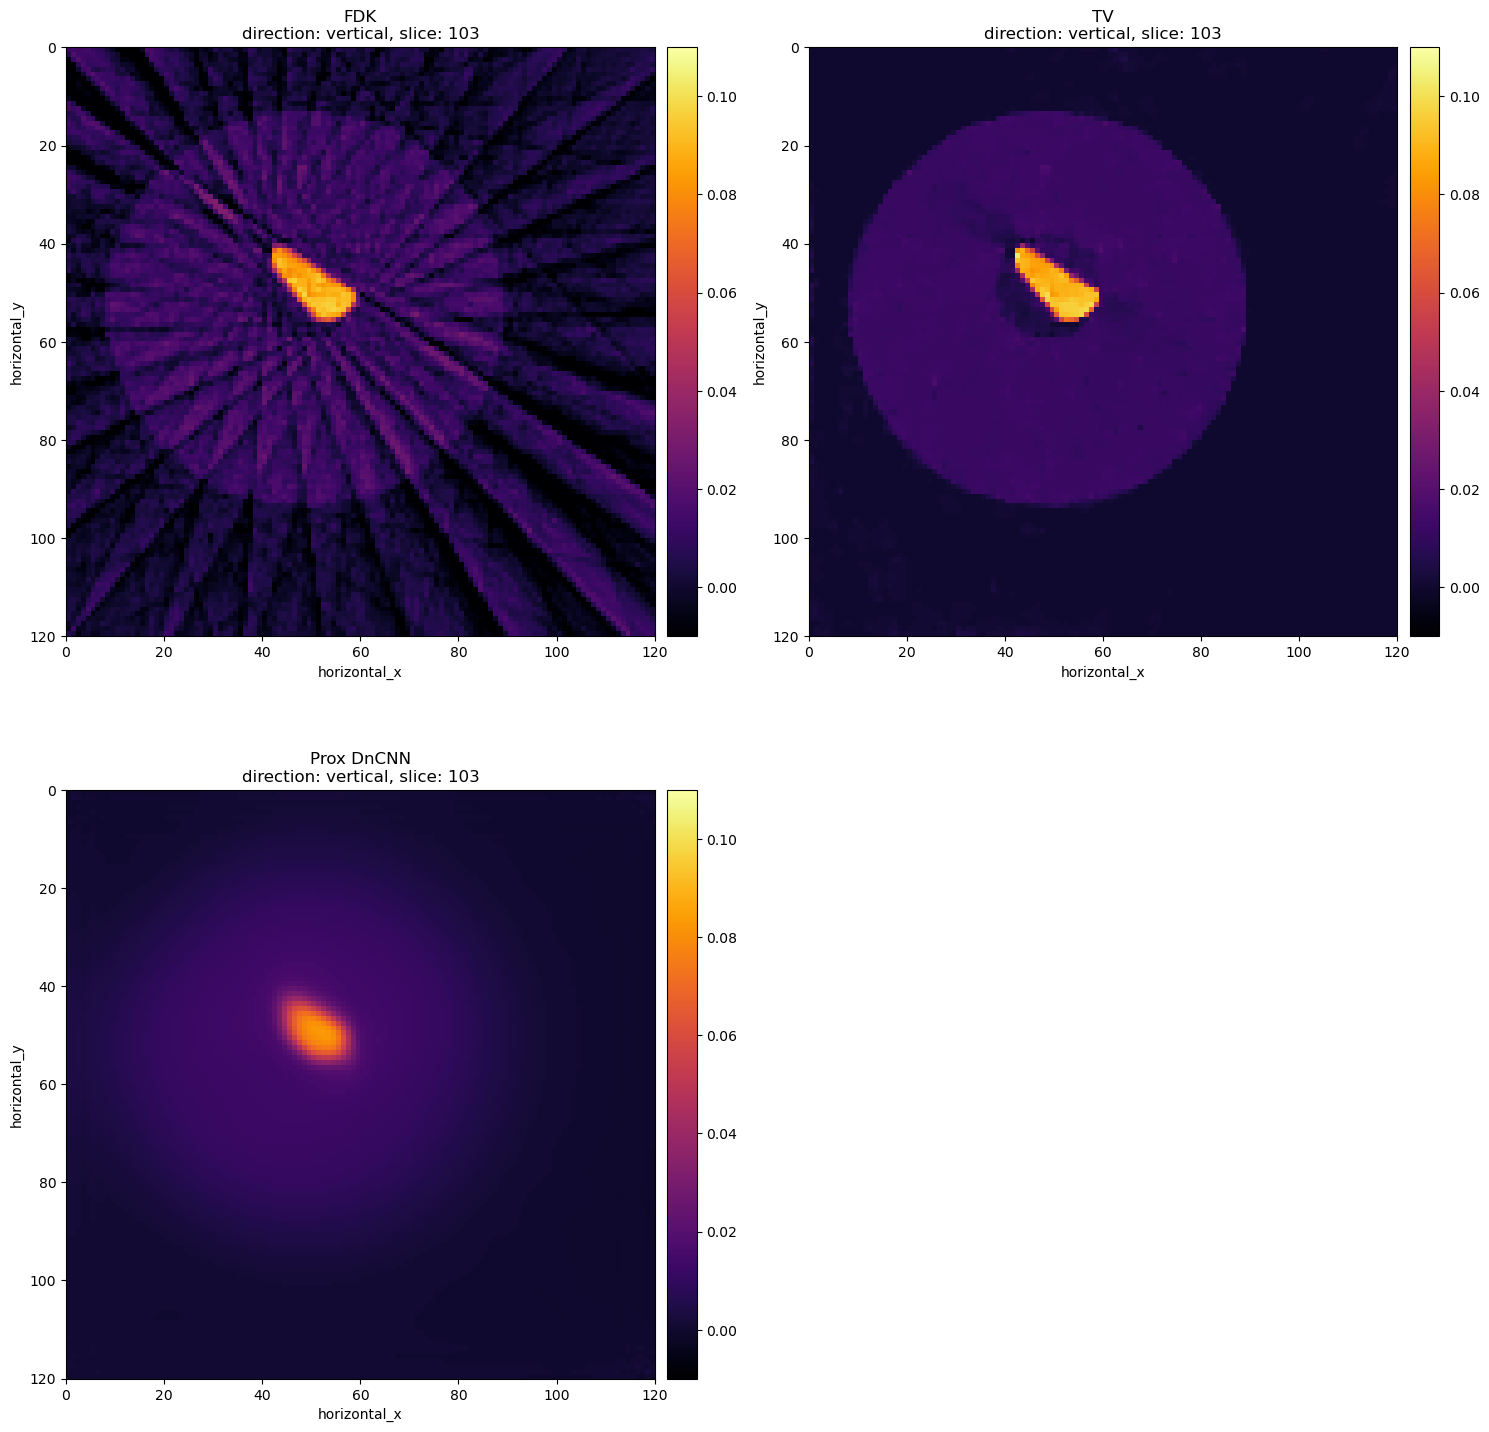

In [13]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution], title=['FDK', 'TV', 'Prox DnCNN'],
            slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


We are careful to clear up after using the torch model, it can use (and sometimes leak) a lot of memory. 

In [14]:
gc.collect()
torch.cuda.empty_cache()

### DRUNet - a noise level aware model

We now consider a noise level aware model - this time DRUNet, with architecture from the paper [Plug-and-Play Image Restoration with Deep Denoiser Prior](https://arxiv.org/abs/2008.13751). It has a U-Net like structure, with convolutional blocks in the encoder and decoder parts. The network takes into account the noise level of the input image, which is encoded as an additional input channel.

In [15]:
model = deepinv.models.DRUNet(in_channels=1, out_channels=1, pretrained='download', device=device)


#### Too large regularisation parameter ($\lambda = 20$)
This first regularisation parameter we try looks too large. Again the results are oversmoothed:  

  0%|          | 0/50 [00:00<?, ?it/s]

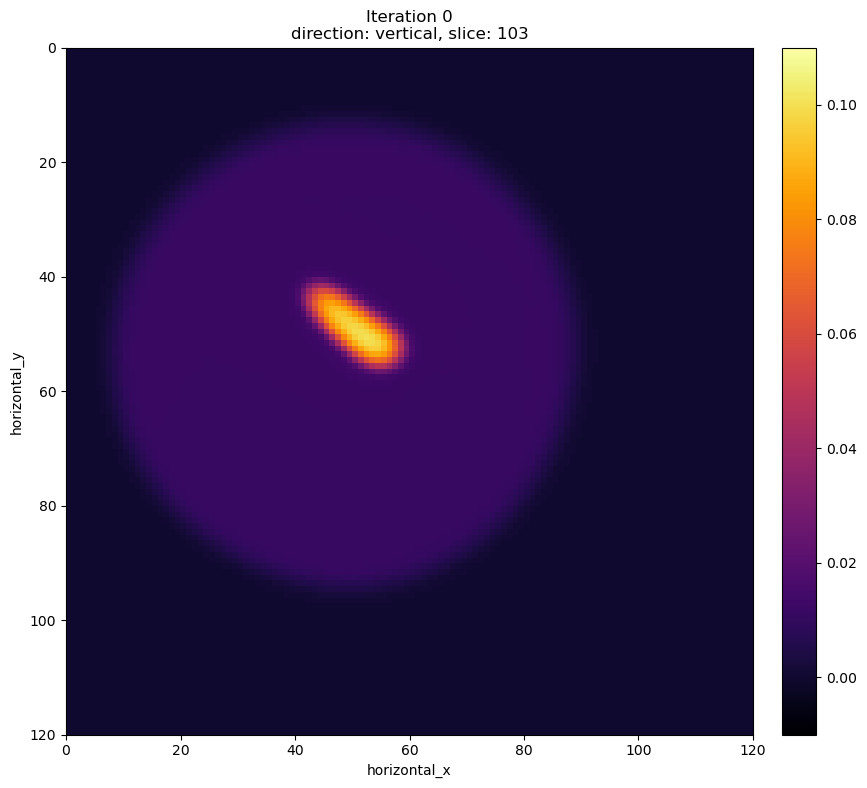

 51%|#####1    | 51/100 [00:00<?, ?it/s]

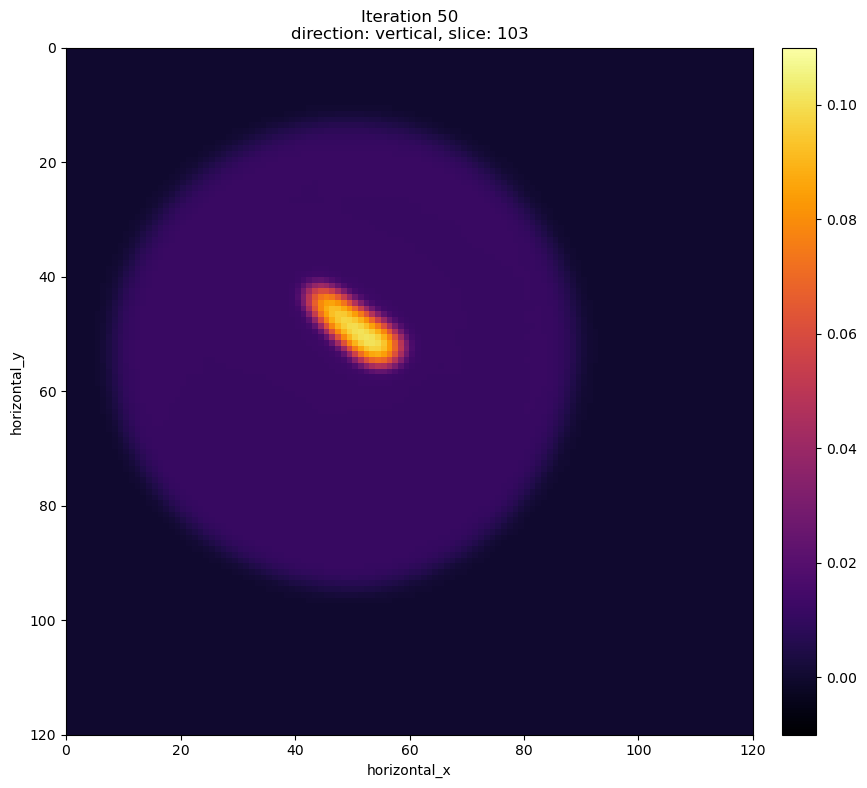

 67%|######7   | 101/150 [00:00<?, ?it/s]

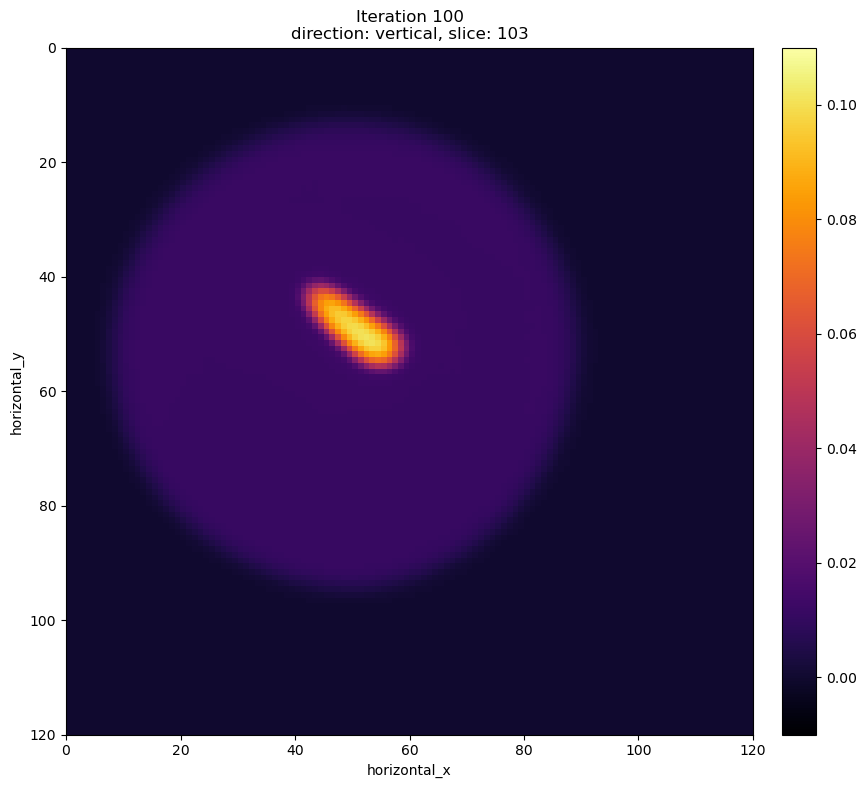

 76%|#######5  | 151/200 [00:00<?, ?it/s]

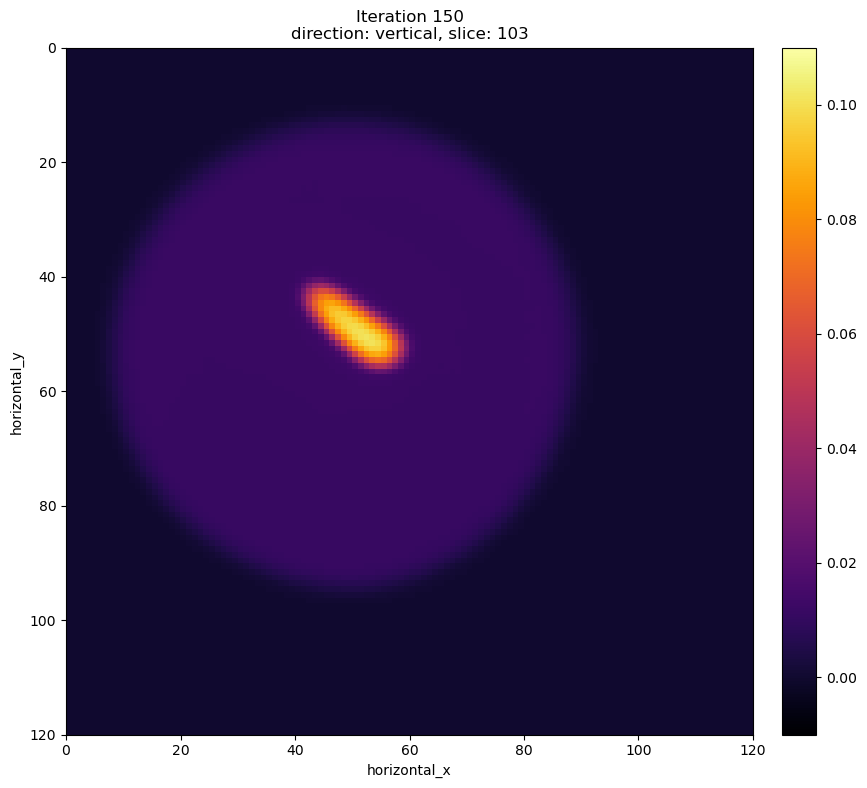

In [16]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
lamb=20
Regulariser = lamb*DenoiserProximal(model=model, device=device)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


#### Too small regularisation parameter ($\lambda=0.5$)
This time we have a value which is postentially too small. The limited angle artefacts are not treated as "noise" and instead the denoiser tries to recreate these artefacts to produce images similar to what it saw during training: it looks like the model is trying to make curtains or fabric to me! With this model and this regularisation parameter and automatic step size choice from FISTA, the algorithm is not converegent! 


  0%|          | 0/50 [00:00<?, ?it/s]

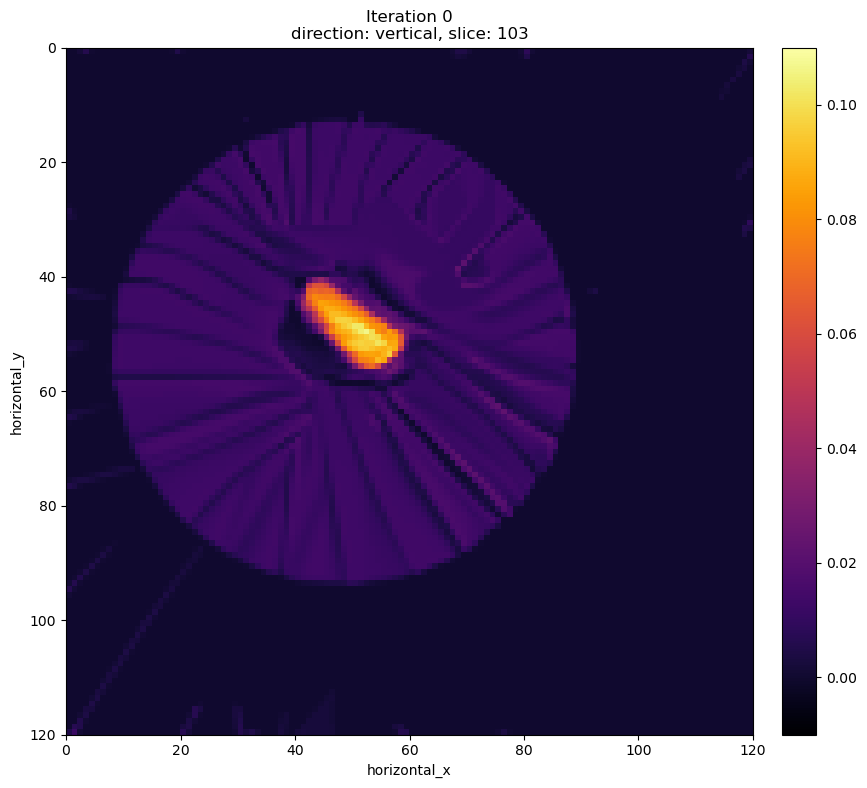

 51%|#####1    | 51/100 [00:00<?, ?it/s]

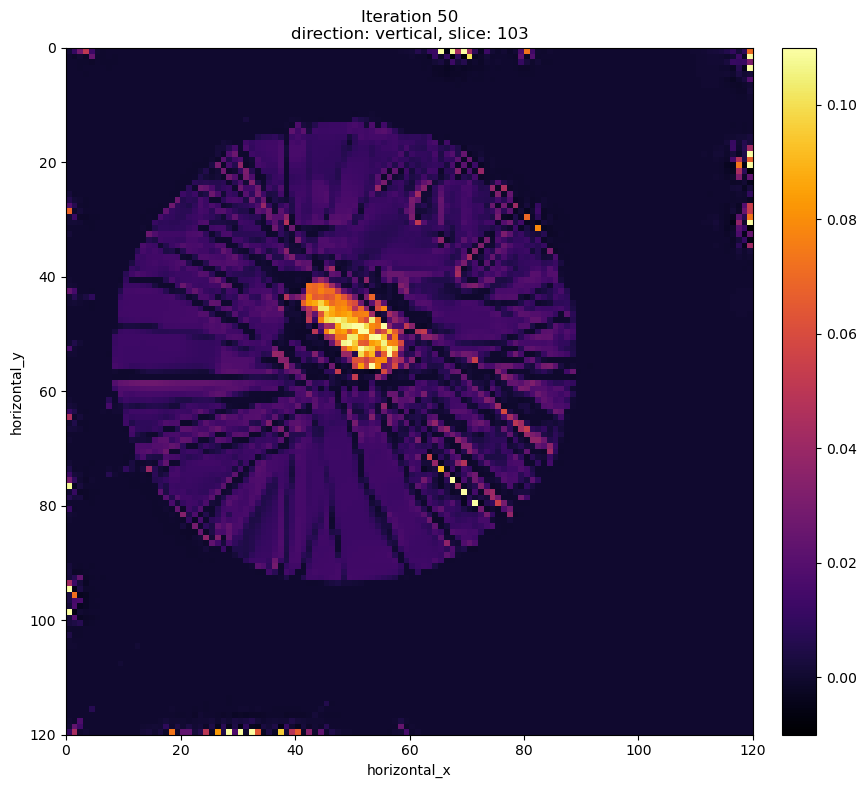

 67%|######7   | 101/150 [00:00<?, ?it/s]

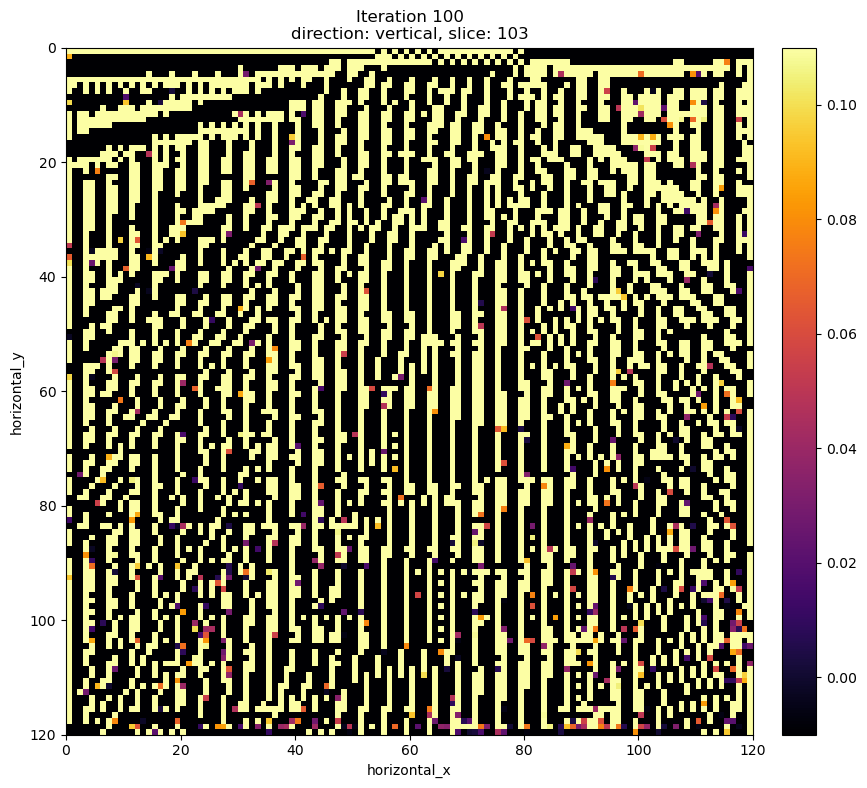

 76%|#######5  | 151/200 [00:00<?, ?it/s]

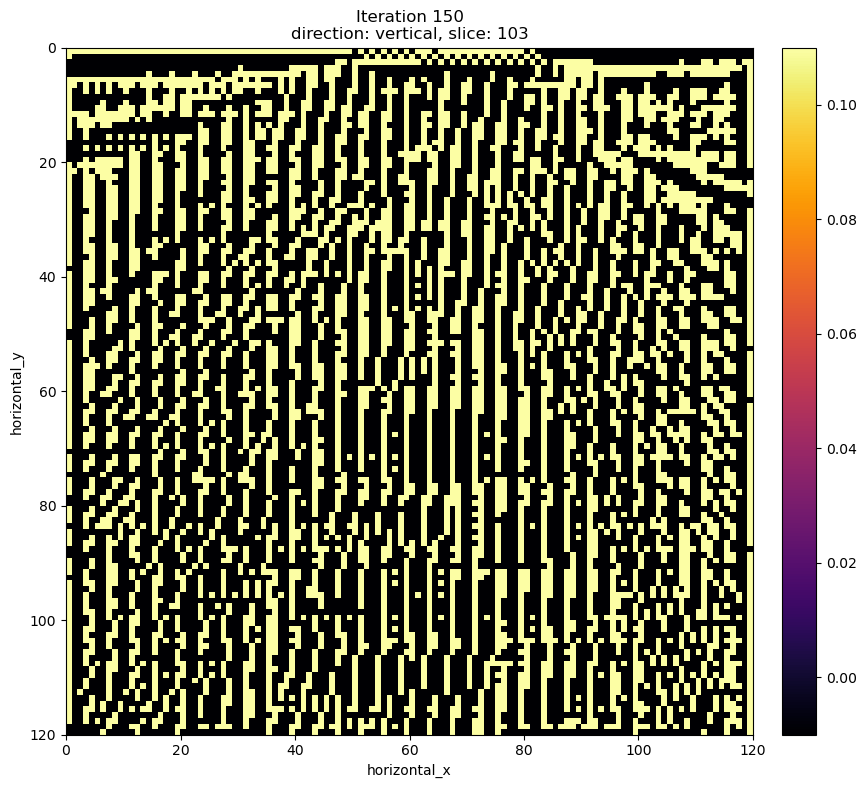

In [17]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
lamb=0.5
Regulariser = lamb*DenoiserProximal(model=model, device=device)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


#### About right (?) regularisation parameter ($\lambda = 3$)

An intermediate value gives a better result. Disclaimer: this is probably not the optimal $\lambda$ parameter, just the best result from a limited few values we tried

  0%|          | 0/50 [00:00<?, ?it/s]

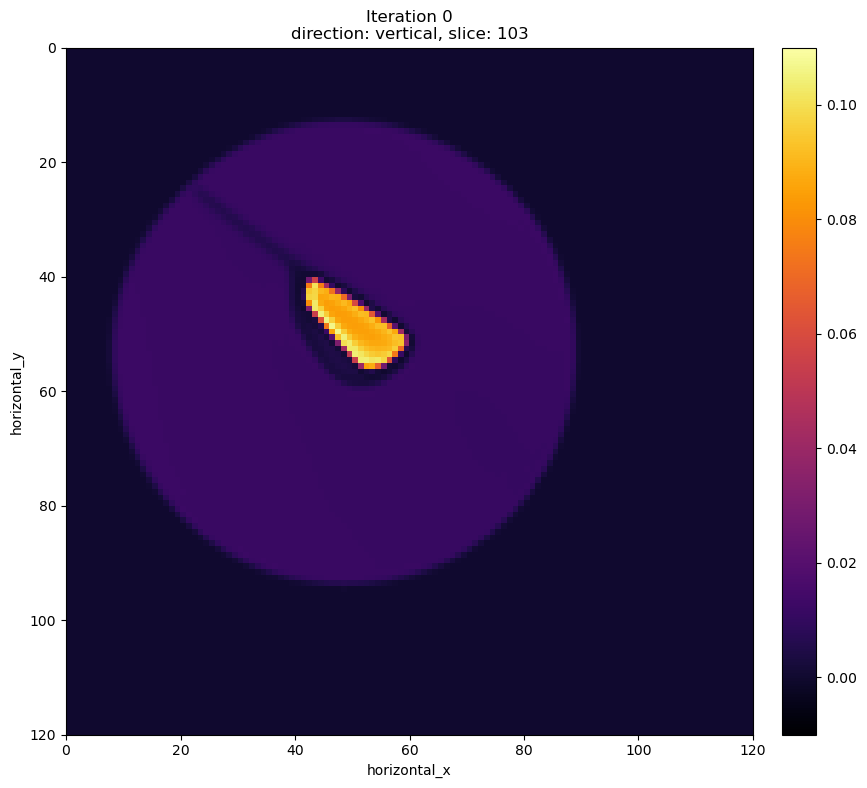

 51%|#####1    | 51/100 [00:00<?, ?it/s]

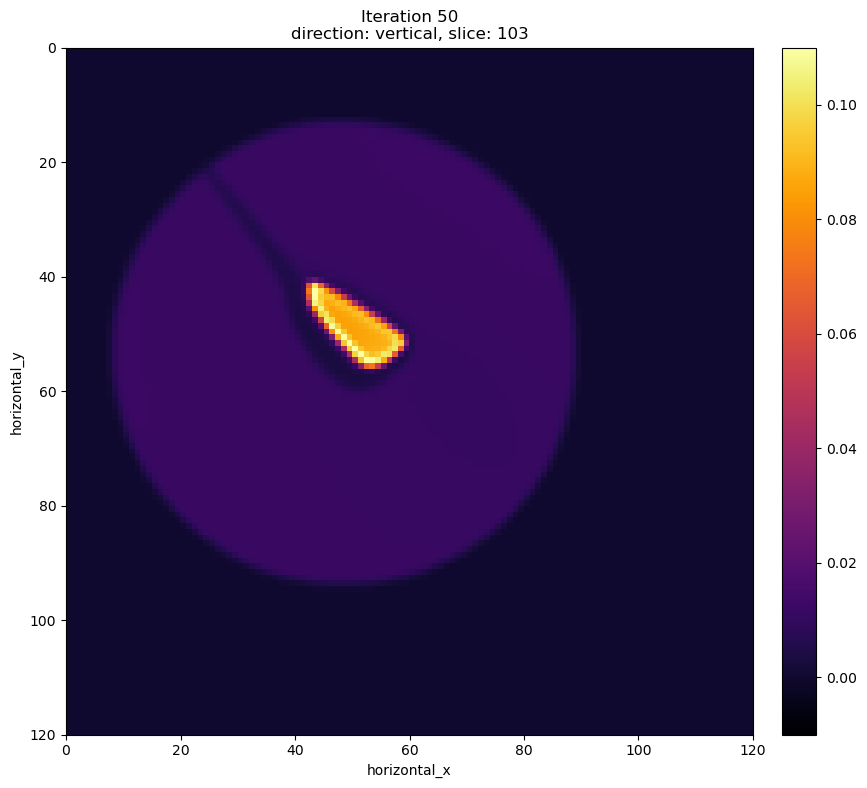

 67%|######7   | 101/150 [00:00<?, ?it/s]

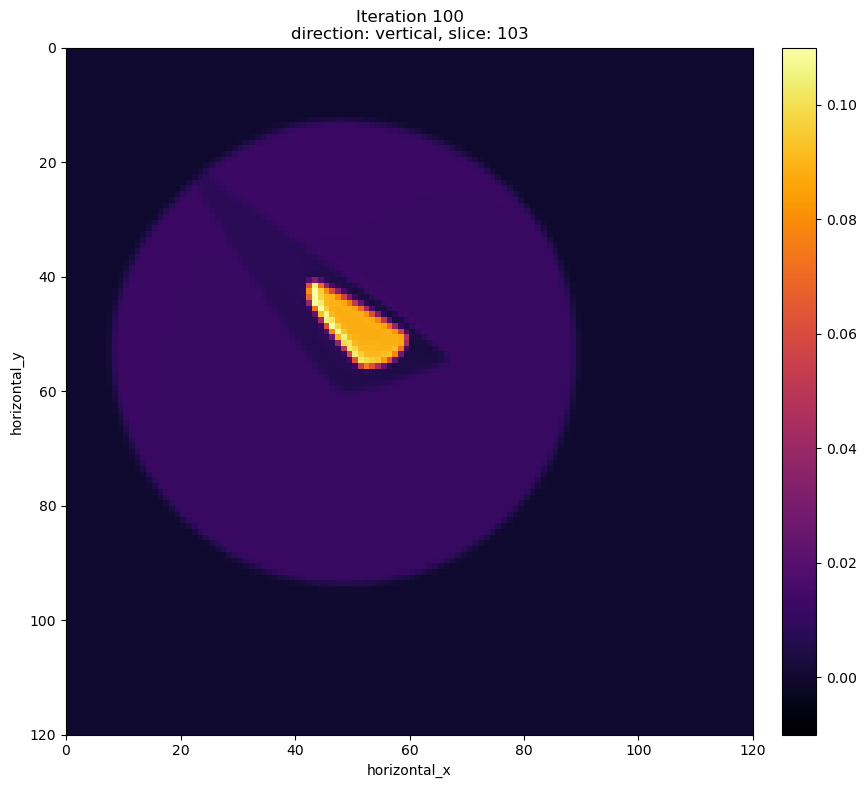

 76%|#######5  | 151/200 [00:00<?, ?it/s]

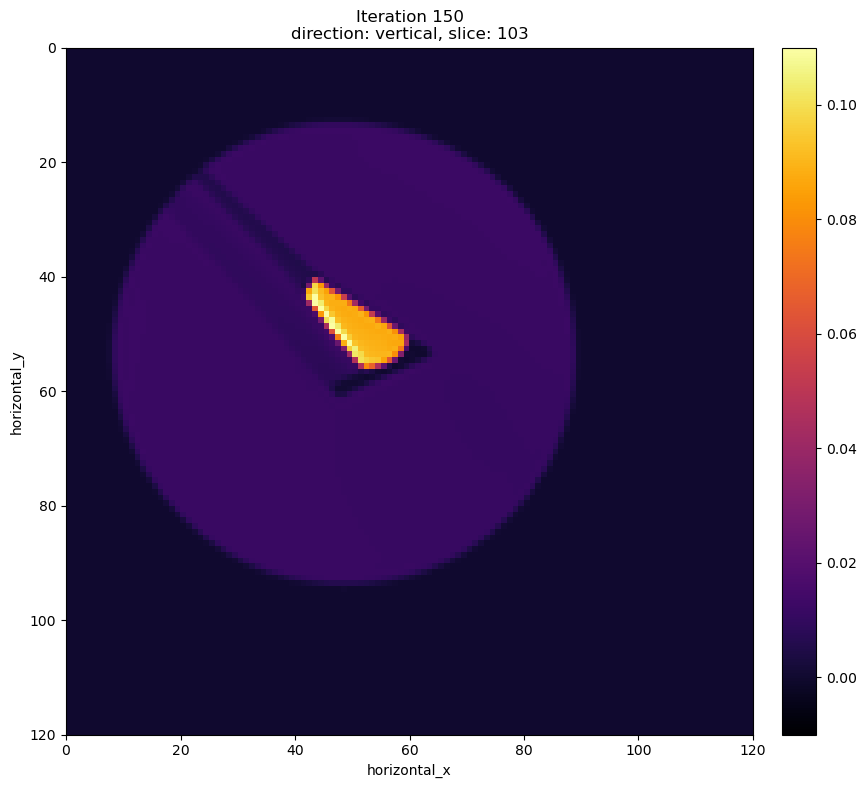

In [18]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
lamb=3
Regulariser = lamb*DenoiserProximal(model=model, device=device)
myFISTADRUNet2D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet2D.run(50,verbose=1)
    show2D(myFISTADRUNet2D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


We can compare the results of the FDK and TV reconstruction and the two plug and play models we have tried. 

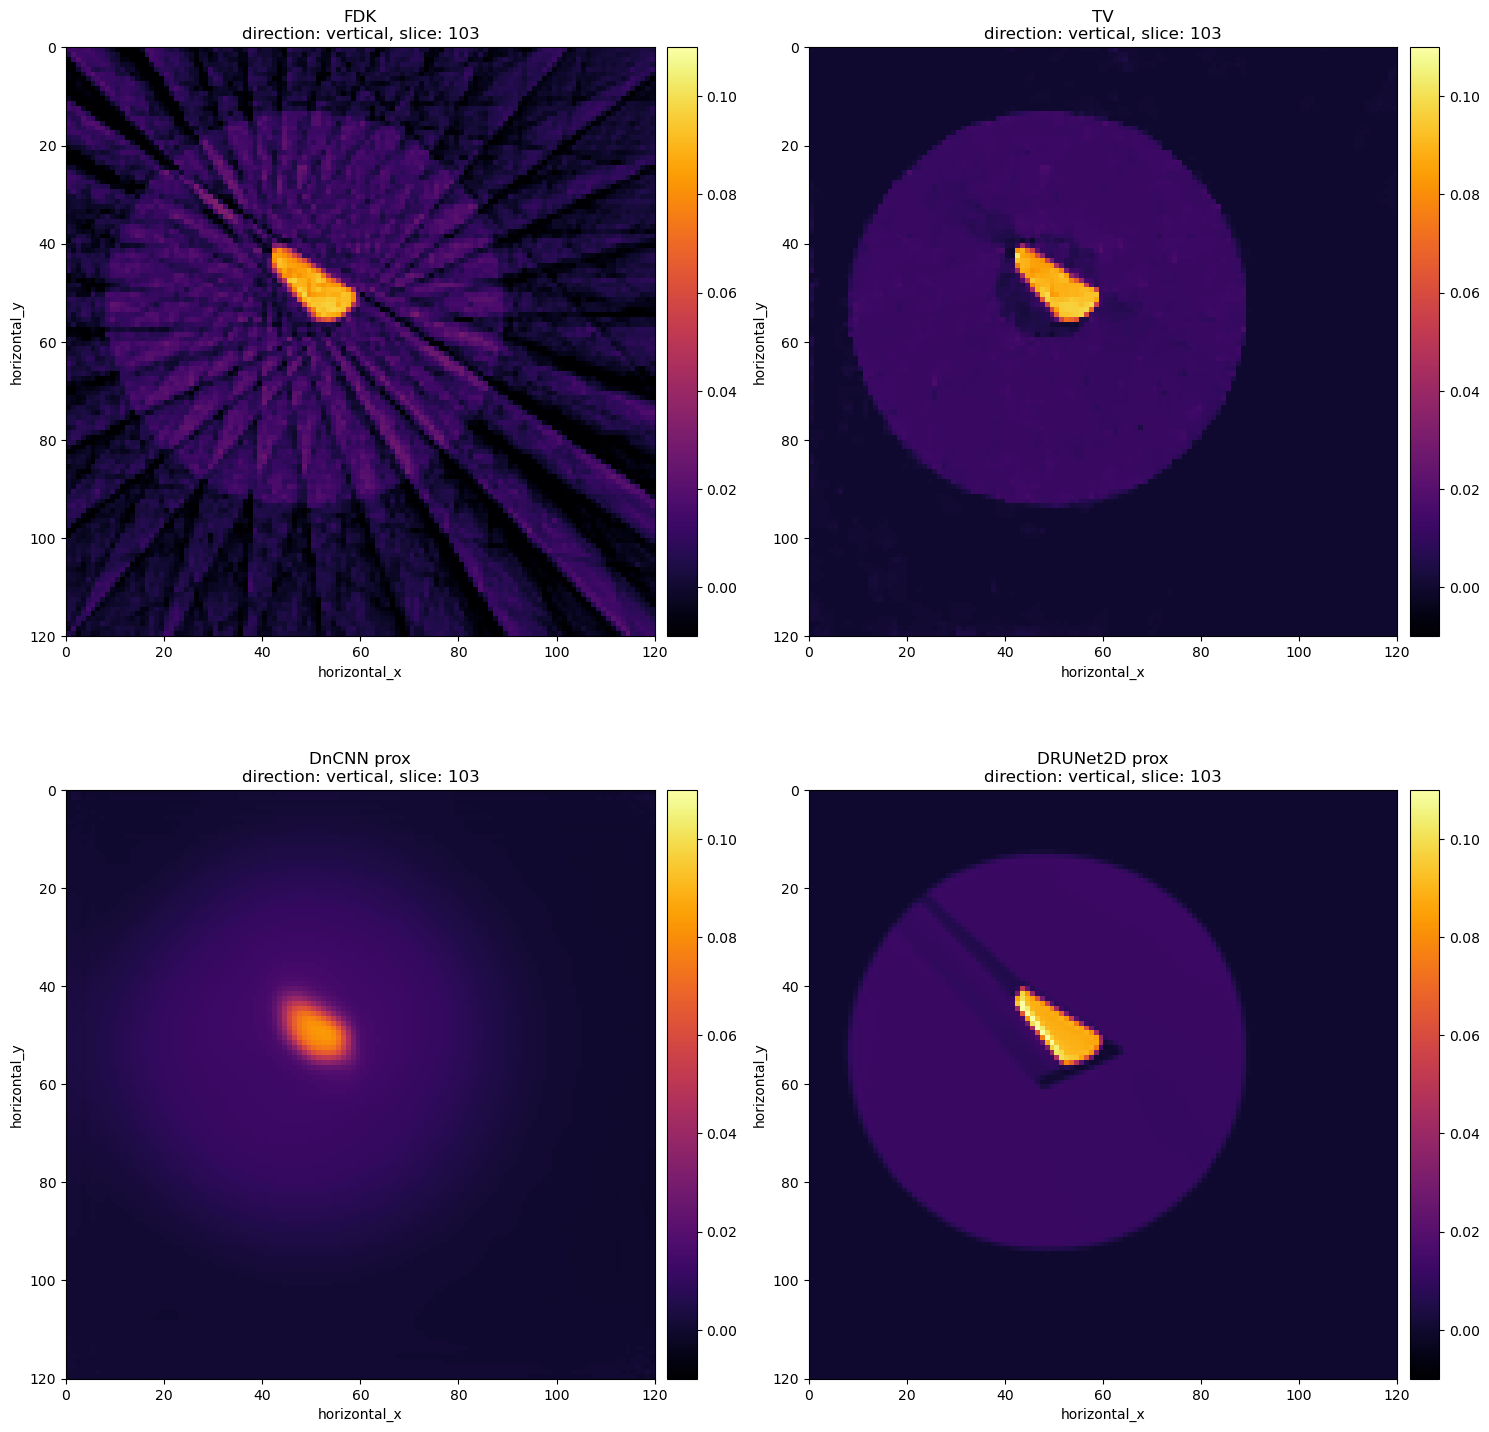

In [19]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution,  myFISTADRUNet2D.solution], title=['FDK', 'TV' , 'DnCNN prox', 'DRUNet2D prox'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

In [20]:
gc.collect()
torch.cuda.empty_cache()

### Aside - cost of copying to and from pytorch 

Copying the data from CIL to torch (and onto the GPU if one exists) and back again could be computationally expensive for large data. In this section we want to work out how long this takes. To do this, we add an extra step in the proximal method where we copy the data to and from torch `n_copy_repeats` times. To make sure that torch actually does the copy, we multiply by a number very close to one after copying to torch. We update the CIL function as follows:  

In [21]:
class DenoiserProximalWithRepeats(DenoiserProximal ):
    
    def __init__(self, model, device='cuda:1',  n_copy_repeats=0):
        self.n_copy_repeats = n_copy_repeats
        super(DenoiserProximalWithRepeats, self).__init__(model = model, device = device)

    
    #overwrite the proximal method 
    def proximal(self, x, tau, out=None): 
        if out is None: 
            out = x.geometry.allocate(None)

        with torch.no_grad():
            x_torch = self.cil_to_torch(x)
            for i in range(self.n_copy_repeats):
                x_torch *= (1.0 - 1e-14)
                self.torch_to_cil(x_torch, x)
                x_torch = self.cil_to_torch(x)
    
            x_torch = self.model(x_torch, tau)
            self.torch_to_cil(x_torch, out)
        return out 
        

In [22]:
def run_DRUProx_recon(n_iterations=200, n_copy_repeats=0):
    start = time()
    F = LeastSquares(A, b)
    x0 = ig.allocate(0.0)
    lamb=0.02
    Regulariser = lamb*DenoiserProximalWithRepeats(model=model, device=device, n_copy_repeats=n_copy_repeats)
    myFISTADRUNet = FISTA(f=F, 
                      g=Regulariser, 
                      initial=x0 ,
                      update_objective_interval = 10)
    myFISTADRUNet.run(n_iterations, verbose=1)
    end = time()
    return end - start

def plot_copying_overhead(n_iterations=200, max_n_copy_repeats=6):
    fig, axs = plt.subplots(1)
    ncrs = [0, 1, 2, 4, 6]
    while ncrs[-1] < max_n_copy_repeats:
        ncrs += [ncr*10 for ncr in ncrs[-4:]]
    while ncrs[-1] > max_n_copy_repeats:
        ncrs = ncrs[:-1]
    timings = {ncr: run_DRUProx_recon(n_iterations, n_copy_repeats=ncr) for ncr in ncrs}
    axs.plot(timings.keys(), timings.values())
    axs.set_xlabel('Number of copy repeats in each proximal')
    axs.set_ylabel('Total time for {} iterations'.format(n_iterations))
    return list(timings.keys()), list(timings.values())

We can now plot the results of doing 2 iterations of the FISTA algorithm, copying 0 to 20 times in each proximal calculation

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Seconds for a copy back and forth :  0.004042650972093854


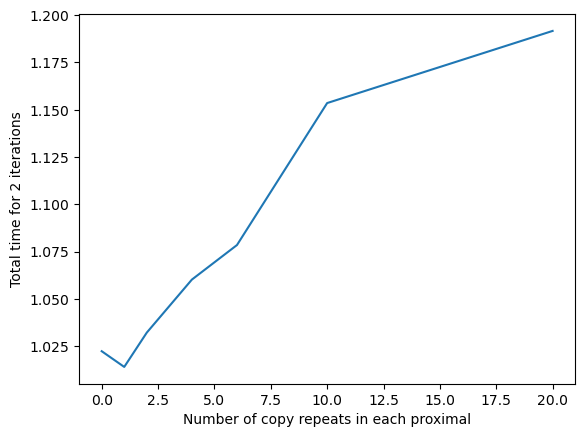

In [23]:
keys, values = plot_copying_overhead(2, 20)
print( 'Seconds for a copy back and forth : ', (values[-1]-  values[-3])/(2*(keys[-1]-  keys[-3])))

We can now plot the results of doing 15 iterations of the FISTA algorithm, copying 0 to 100 times in each proximal calculation

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Seconds for a copy back and forth :  0.005092268255021837


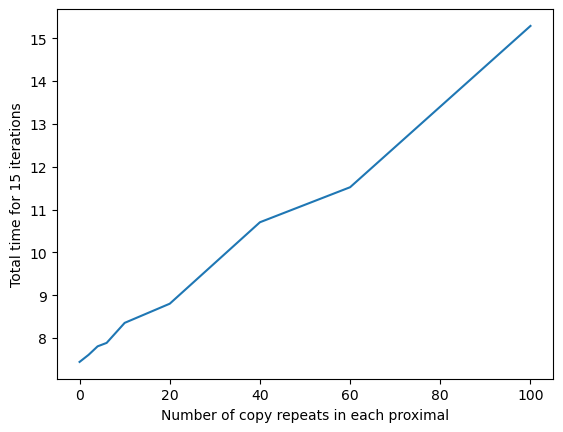

In [24]:
keys, values = plot_copying_overhead(15, 100)
print( 'Seconds for a copy back and forth : ', (values[-1]-  values[-3])/(15*(keys[-1]-  keys[-3])))

### How to deal with 3D data

All looks brilliant. However, we were dealing with 3D data and currently we are denoising the images with a 2D denoiser, slice by slice. What if we visualise the data in a different plane: 

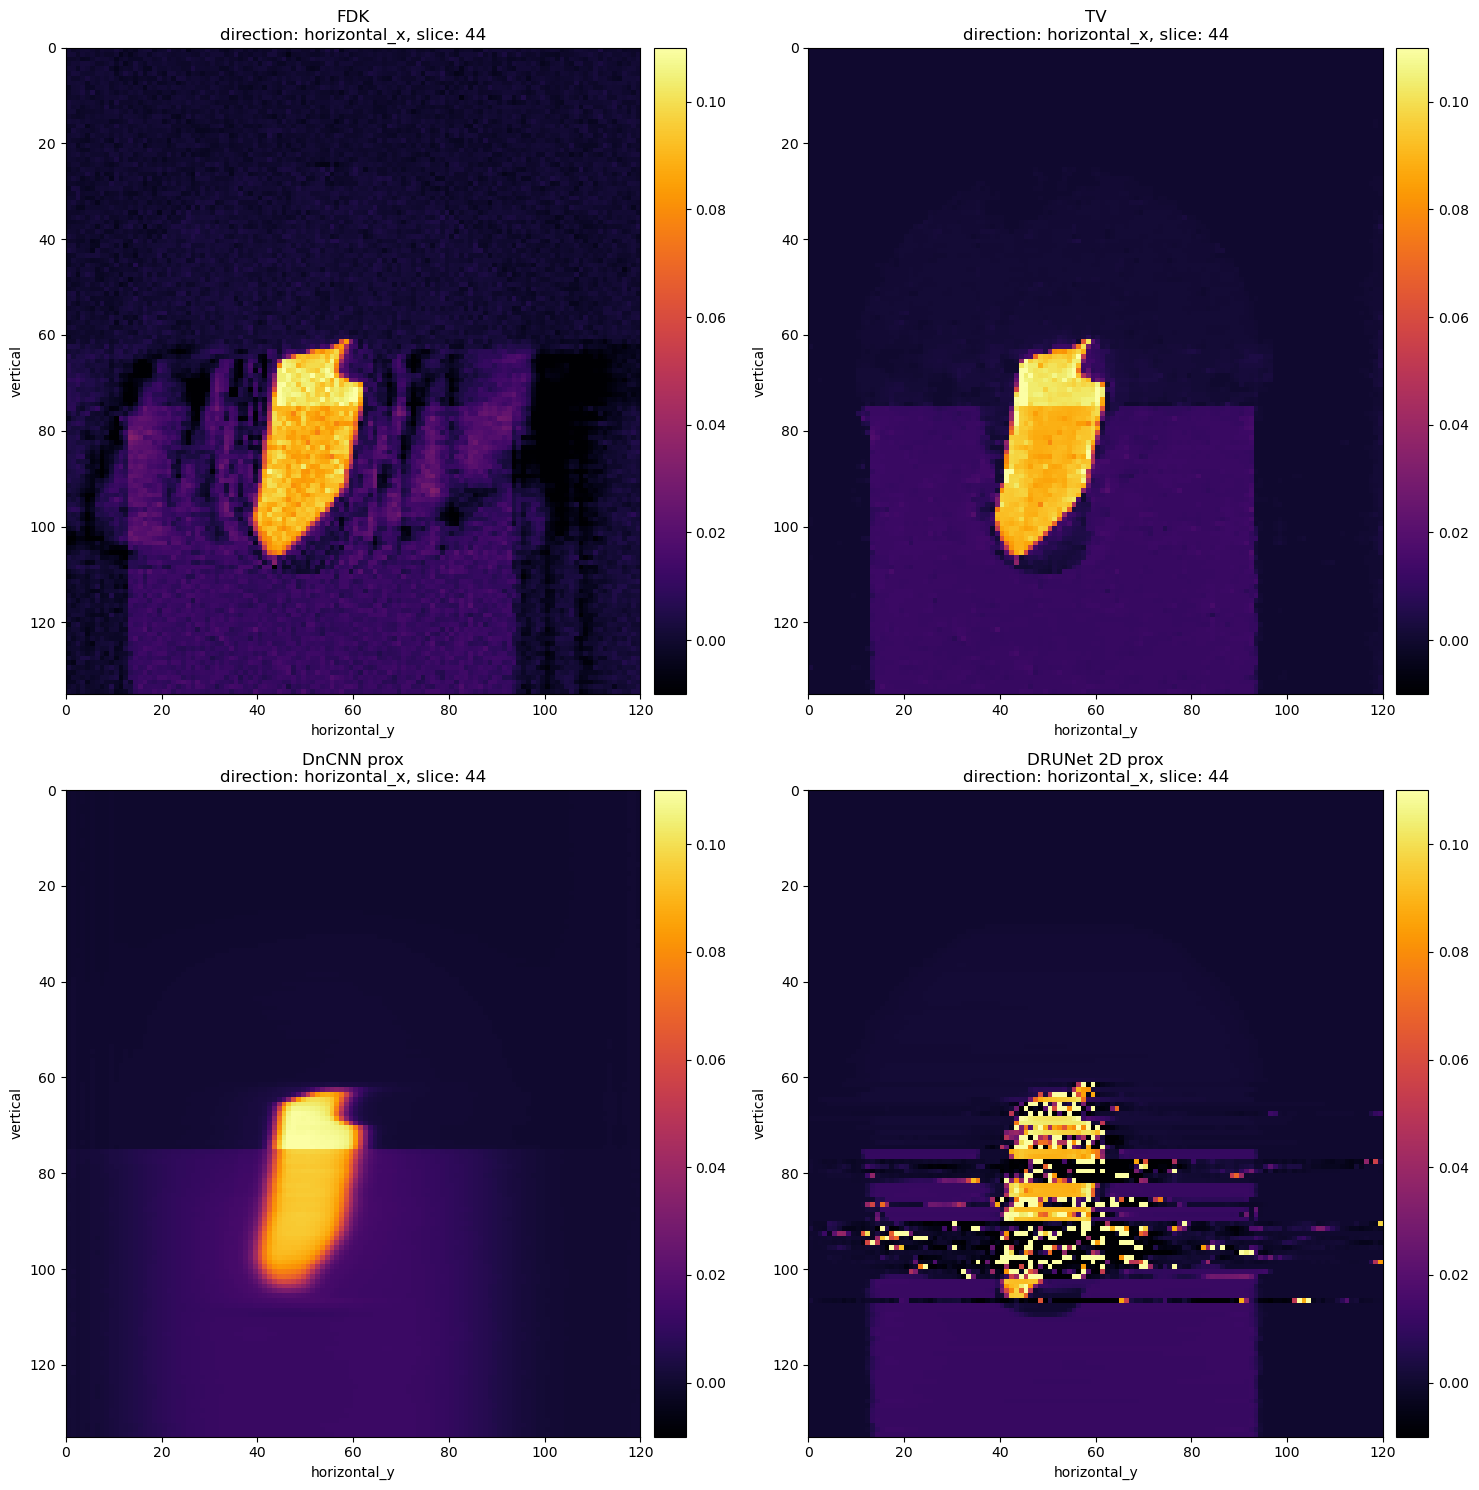

In [25]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution], title=['FDK', 'TV' ,'DnCNN prox', 'DRUNet 2D prox'],
     slice_list=('horizontal_x',sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

Oh dear! We have lost any consistency in this vertical plane and the reconstruction, although it looked ok, is mostly useless. 3D volume denoisers are rare because of the data sizes involved and lack of training data. In the next section, we instead create a hacky solution by applying the denoiser 3 times, once  in the horizontal and once in the vertical plane, for each call of the proximal. 

#### DRUNet - noise level aware - applied three times! 

In [26]:
class DenoiserProximal3D(DenoiserProximal ):
    
    def __init__(self, model, device='cuda:1'):


        super(DenoiserProximal3D, self).__init__(model, device)

    def proximal(self, x, tau, out=None): 
        if out is None: 
            out = x.geometry.allocate(None)


        with torch.no_grad():
            x_torch = self.cil_to_torch(x)
            
            x_torch = self.model(x_torch, tau)
            
            x_torch = x_torch.permute( 2, 1, 0, 3 ) #permute
            x_torch= self.model(x_torch, tau)
            x_torch = x_torch.permute( 2, 1, 0, 3 ) #permute back
        
            #x_torch = x_torch.permute( 3, 1, 2, 0 ) # permute 
            #x_torch= self.model(x_torch, tau)
            #x_torch = x_torch.permute( 3, 1, 2, 0 ) # permute back 
            
            self.torch_to_cil(x_torch, out)
        return out 
        


  0%|          | 0/50 [00:00<?, ?it/s]

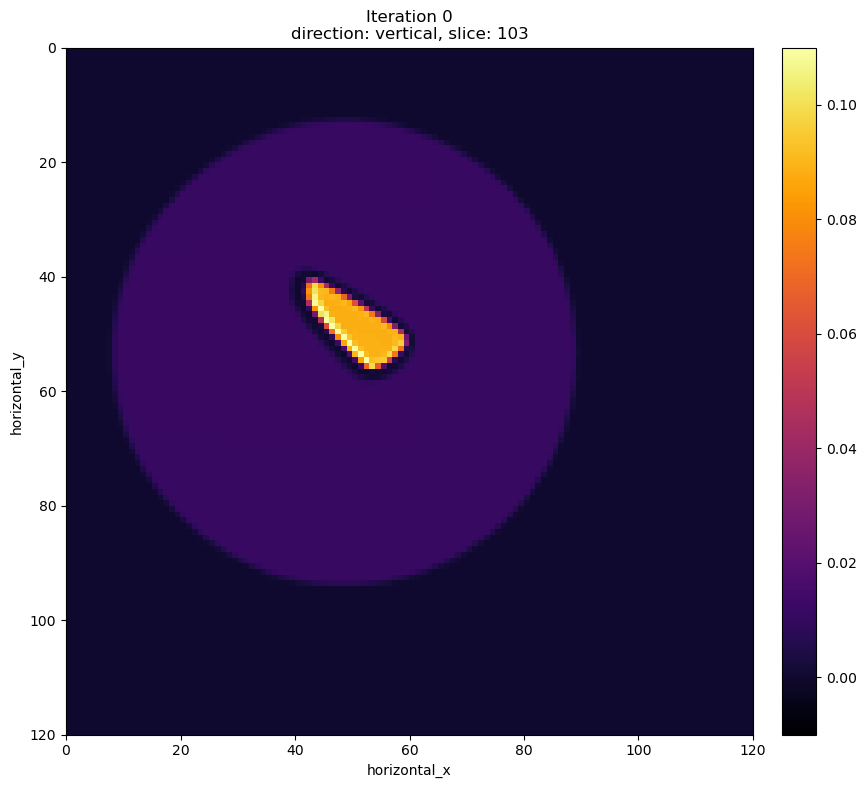

 51%|#####1    | 51/100 [00:00<?, ?it/s]

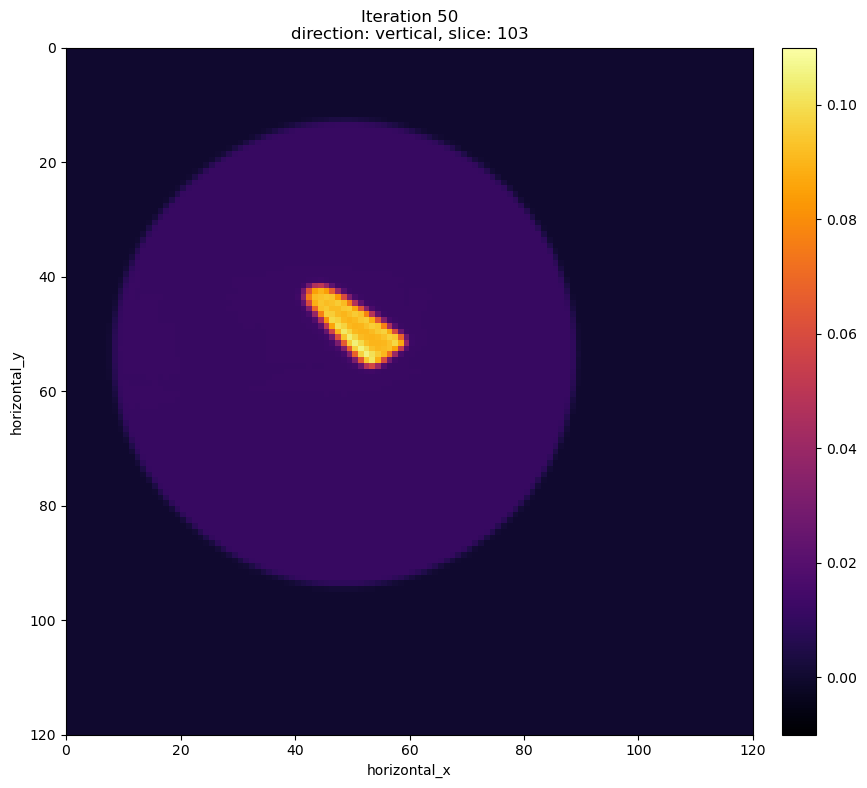

 67%|######7   | 101/150 [00:00<?, ?it/s]

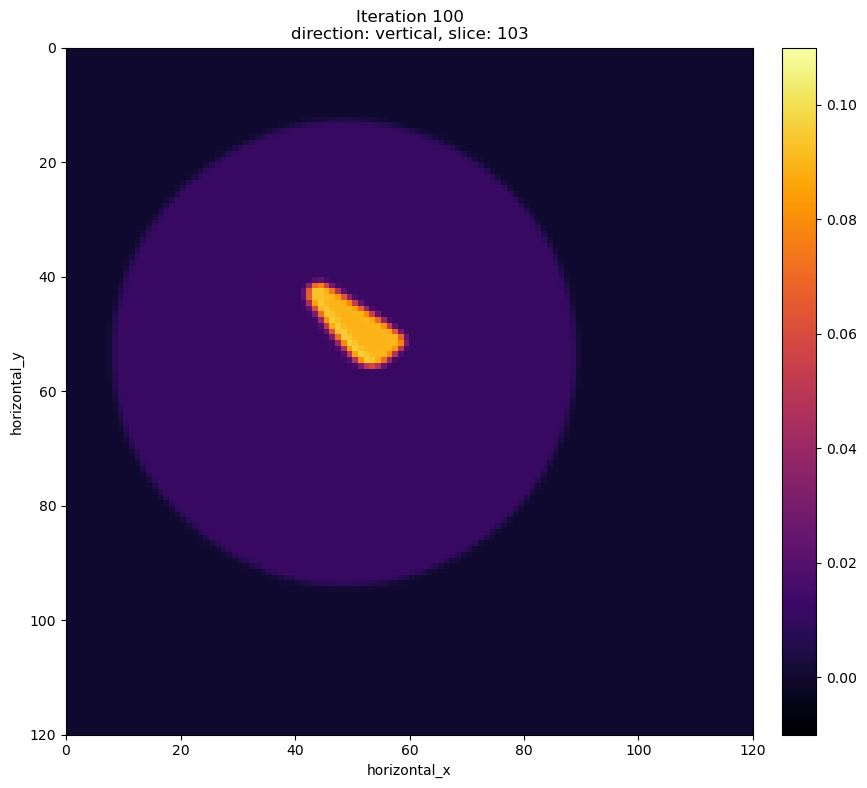

 76%|#######5  | 151/200 [00:00<?, ?it/s]

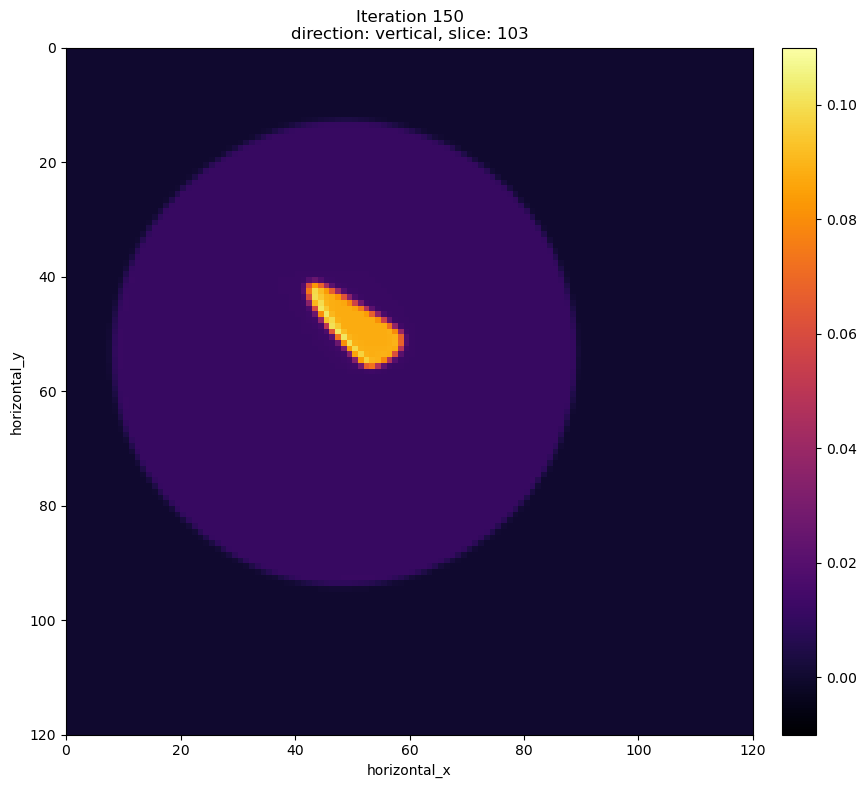

In [27]:
F = LeastSquares(A, b)
x0 = ig.allocate(0.0)
lamb=5
Regulariser = lamb*DenoiserProximal3D(model, device)
myFISTADRUNet3D = FISTA(f=F, 
                  g=Regulariser, 
                  initial=x0 ,
                  update_objective_interval = 10)
for i in range(4):
    myFISTADRUNet3D.run(50,verbose=1)
    show2D(myFISTADRUNet3D.solution, title = 'Iteration {}'.format(i*50), slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')


We can plot our results again, and see much better consistency in the vertical slice. However, there is still some oversmoothing, and we have lost information on the "hole" that the steel wire is sitting in. 

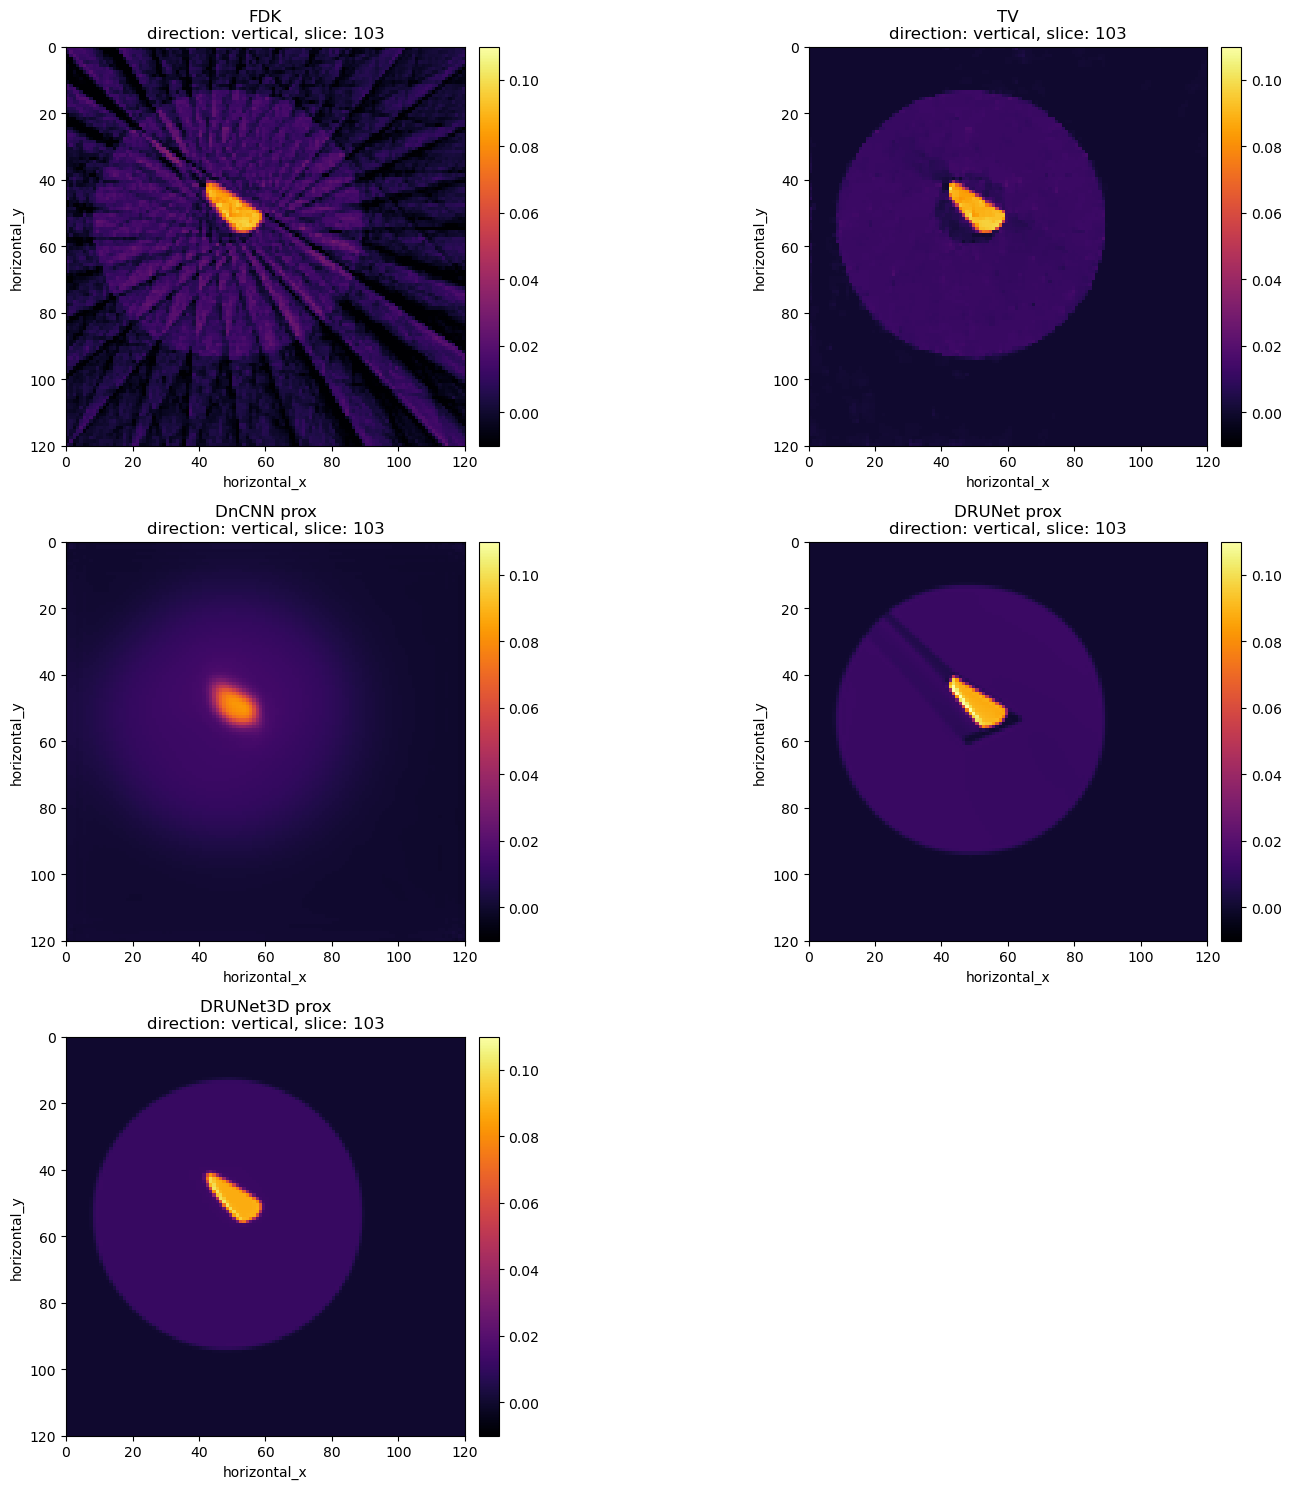

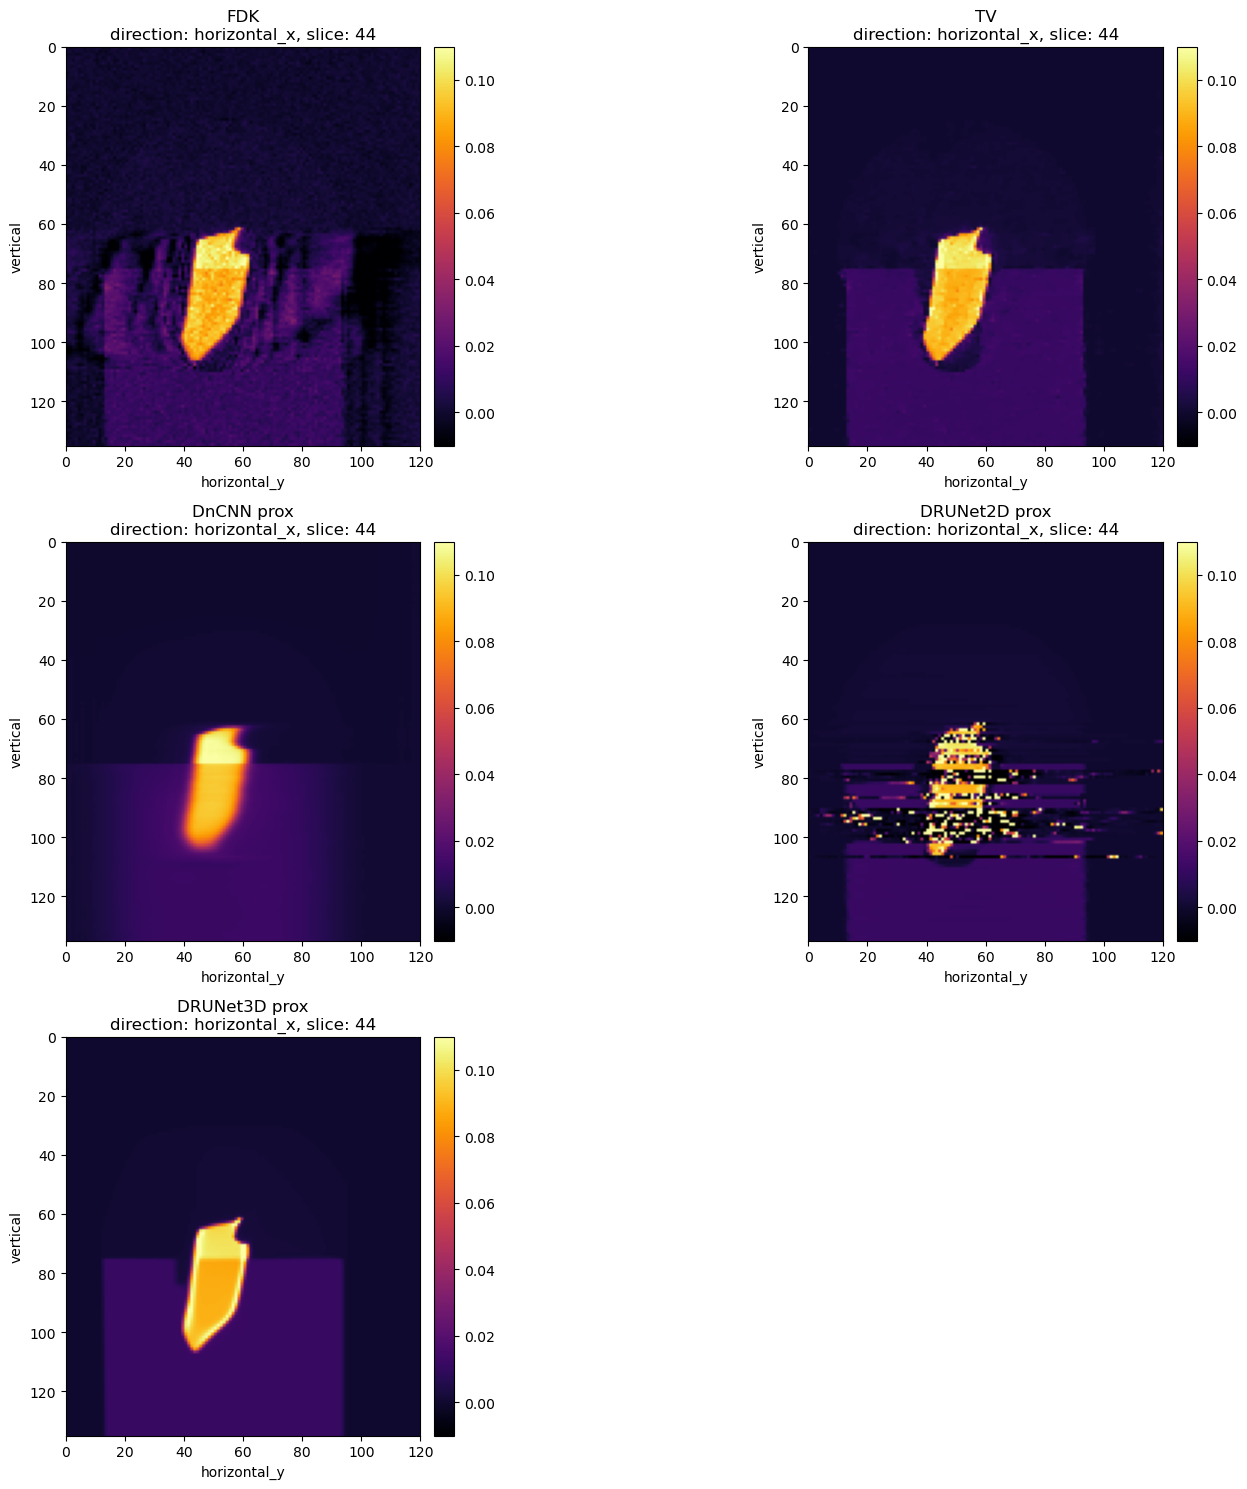

In [28]:
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution, myFISTADRUNet3D.solution, ], title=['FDK', 'TV' , 'DnCNN prox',  'DRUNet prox', 'DRUNet3D prox'],
     slice_list=('vertical',sz), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')
show2D([recon15, myFISTATV.solution, myFISTADnCNN.solution, myFISTADRUNet2D.solution, myFISTADRUNet3D.solution], title=['FDK', 'TV' , 'DnCNN prox', 'DRUNet2D prox', 'DRUNet3D prox'],
    slice_list=('horizontal_x',sx), cmap='inferno', fix_range=(ca1,ca2), origin='upper-left')

In [29]:

gc.collect()
torch.cuda.empty_cache()

## Summary

This notebook covers: 
- How to set up an environment with CIL and pytorch and deep inverse 
- How to create a CIL function to wrap a pytorch function or operator 
- Examples of image reconstruction using a pre-trained denoiser in CIL 
- Timings of the data copies between pytorch and CIL 
  

## Future work 

There is lots more work that we could have done on this showcase, for example: 
- Investigated different denoiser models:
  - Models trained on tomography datasets or trained to remove limited angle tomography artefacts might be more effective in this case 
  - 3D denoisers, potentially patch based, could remove the need for applying the denoiser twice for each call to proximal 
  - Certain denoisers have different mathematical properties e.g. continuity, convexity etc which leads on to...
- Different algorithms 
  - This trick of replacing the proximal with a denoiser can be done for a range of algorithms with different mathematical convergence properties, see e.g. ["Plug-and-Play ADMM for Image Restoration: Fixed Point Convergence and Applications" Stanley H. Chan, Xiran Wang, Omar A. Elgendy ](https://arxiv.org/abs/1605.01710) or ["Plug and play methods for magnetic resonance imaging (long version)", Rizwan Ahmad, Charles A. Bouman, Gregery T. Buzzard, Stanley Chan, Sizhou Liu, Edward T. Reehorst, Philip Schniter](https://arxiv.org/abs/1903.08616)
- Tried with different data 
  - We could have considered different levels of noise in the data or different numbers of missing angles 
  - In this example, depending on what you were going on to do with the data, the TV reconstruction is still probably best. The plug and play denoisers could be improved by playing around with the regularisation parameters. However, different datasets may be more suited to this method 
- We quantified the cost of copying to a from pytorch (and the GPU if you have it). This was not huge but still the 3D example case is reasonably slow ( 200 iterations in approx 5mins for me) and hopefully this could possibly be improved by:
  - Work to make CIL data containers compatible with pytorch tensors to prevent the additional copies
  - Looking at ways to batch the slices so they can be processed in parallel by the denoiser. 